/var/folders/5d/8qg8qzq57c5f6_1bll1s4q7h0000gn/T/ipykernel_59363/2803437391.py:572: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Stock-Bond RP": port_rets["Stock-Bond RP"].resample("Y").apply(lambda x: (1 + x).prod() - 1),
/var/folders/5d/8qg8qzq57c5f6_1bll1s4q7h0000gn/T/ipykernel_59363/2803437391.py:573: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Stock-Gold RP": port_rets["Stock-Gold RP"].resample("Y").apply(lambda x: (1 + x).prod() - 1),
/var/folders/5d/8qg8qzq57c5f6_1bll1s4q7h0000gn/T/ipykernel_59363/2803437391.py:574: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Stock-Bond-Gold RP": port_rets["Stock-Bond-Gold RP"].resample("Y").apply(lambda x: (1 + x).prod() - 1),
/var/folders/5d/8qg8qzq57c5f6_1bll1s4q7h0000gn/T/ipykernel_59363/2803437391.py:575: FutureWarning: 'Y' is deprecated and will be removed in a future v


Performance Metrics:
                       Stock-Bond RP  Stock-Gold RP  Stock-Bond-Gold RP  \
Annualized Return           0.101314       0.095361            0.104058   
Annualized Volatility       0.109856       0.110232            0.108278   
Sharpe Ratio                0.922246       0.865091            0.961030   
Maximum Drawdown           -0.244703      -0.191932           -0.204079   
2008 Crisis                -0.079118      -0.129543           -0.027752   
2020 COVID                 -0.053725      -0.091135           -0.004687   
2025 Tariffs               -0.042146       0.025436            0.021607   

                       SPY (unleveraged)  SPY (leveraged)  Bonds (leveraged)  \
Annualized Return               0.117271         0.079430           0.040821   
Annualized Volatility           0.196955         0.108577           0.103502   
Sharpe Ratio                    0.595424         0.731558           0.394400   
Maximum Drawdown               -0.551894        -0.237883

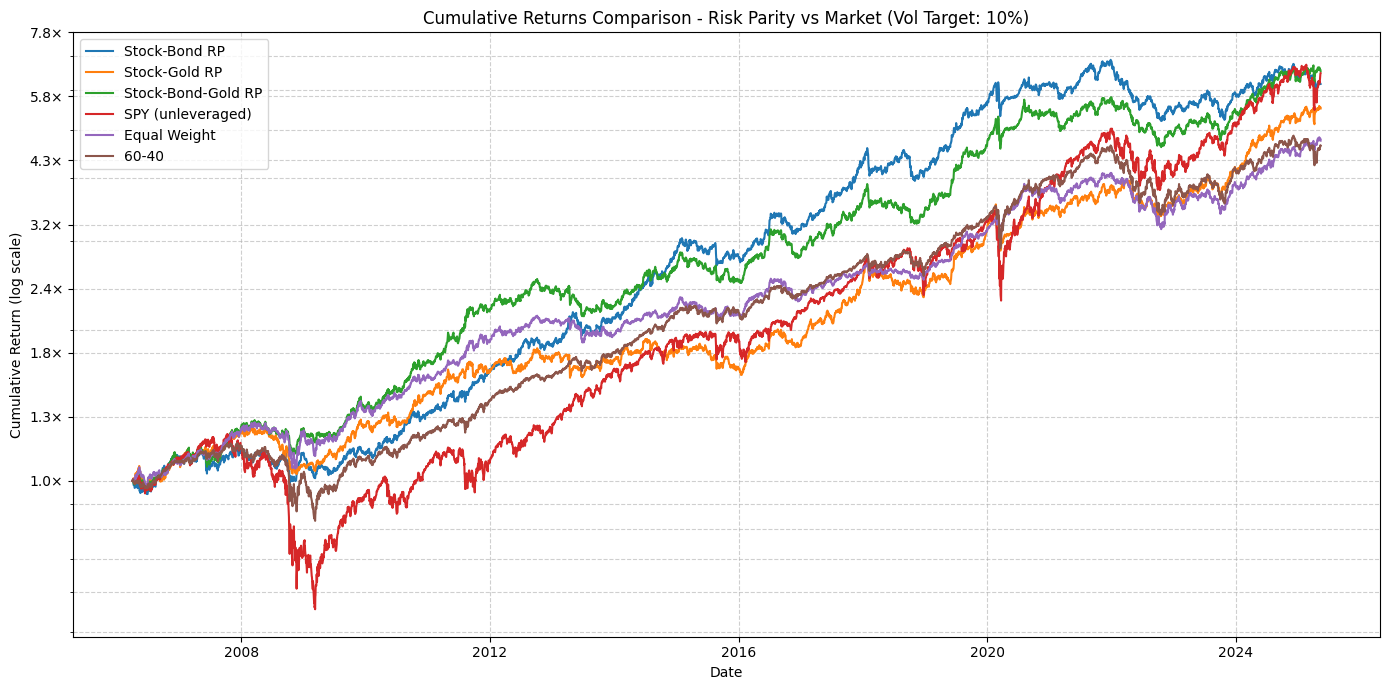

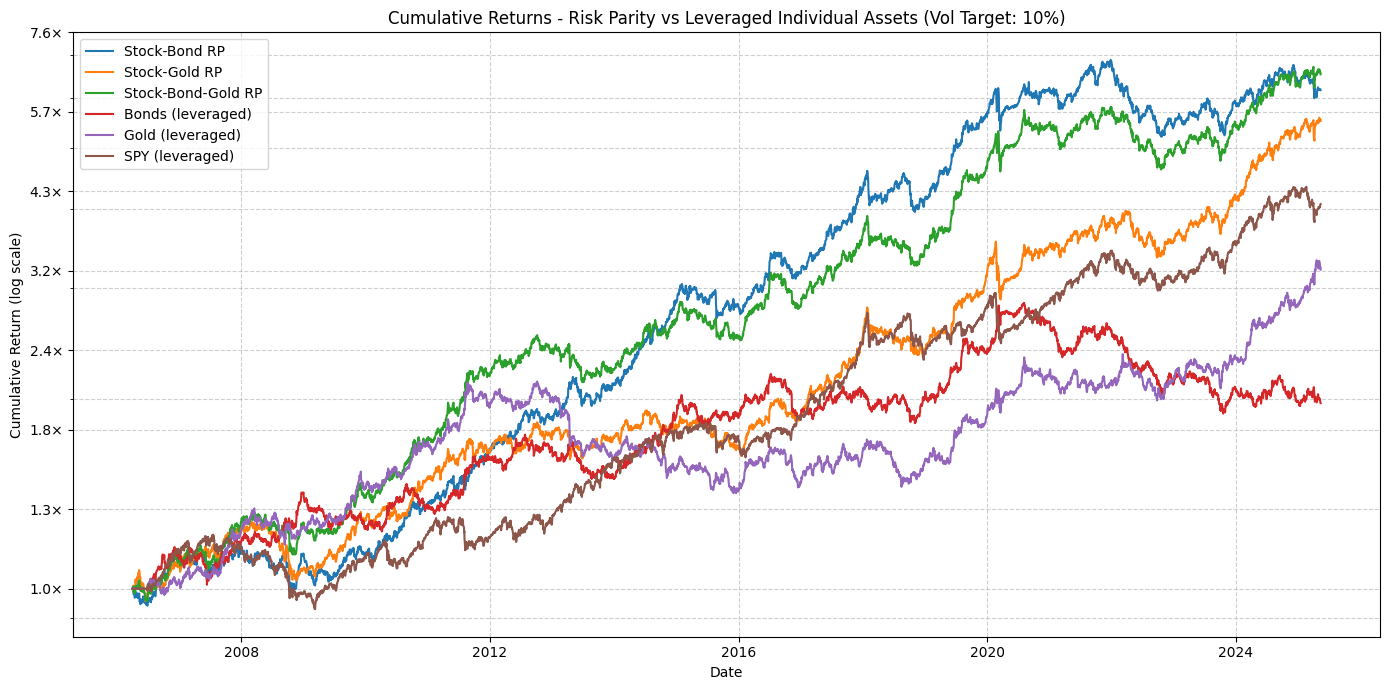

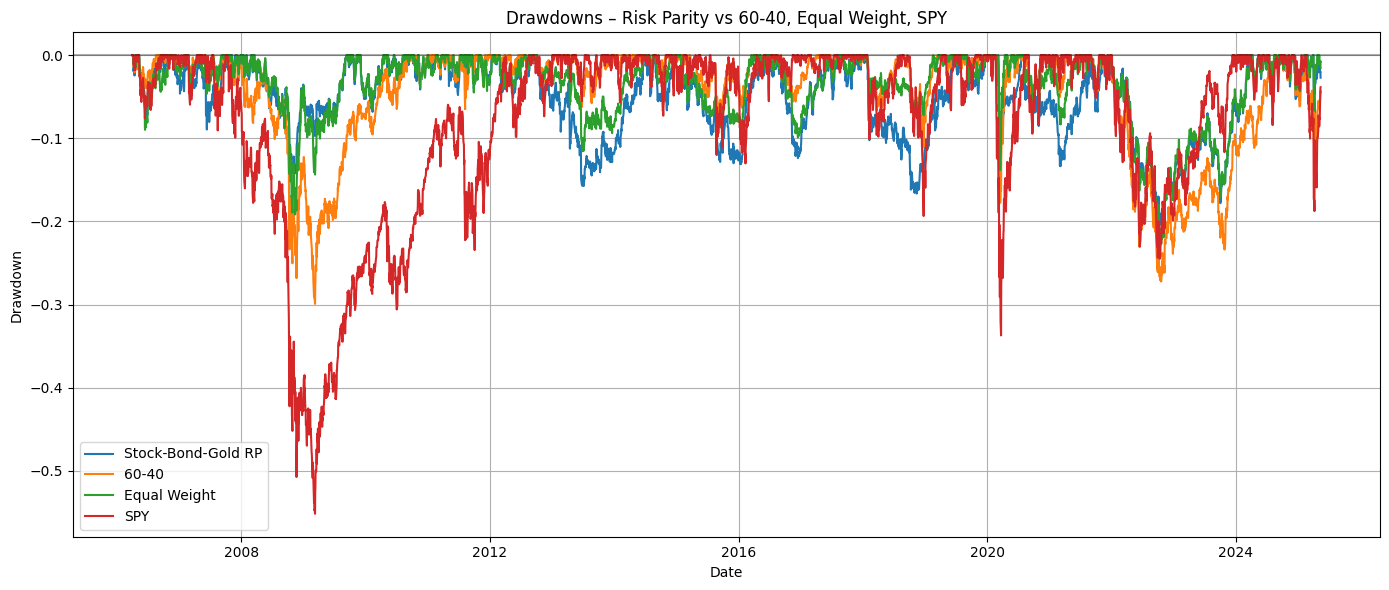

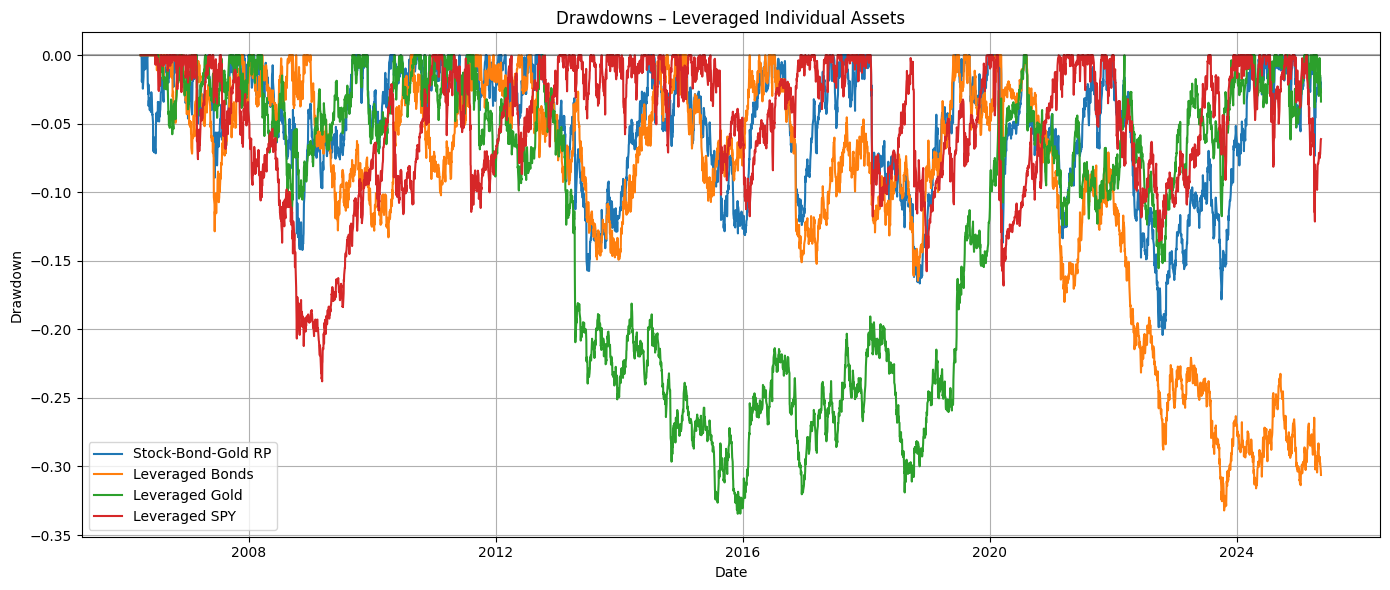

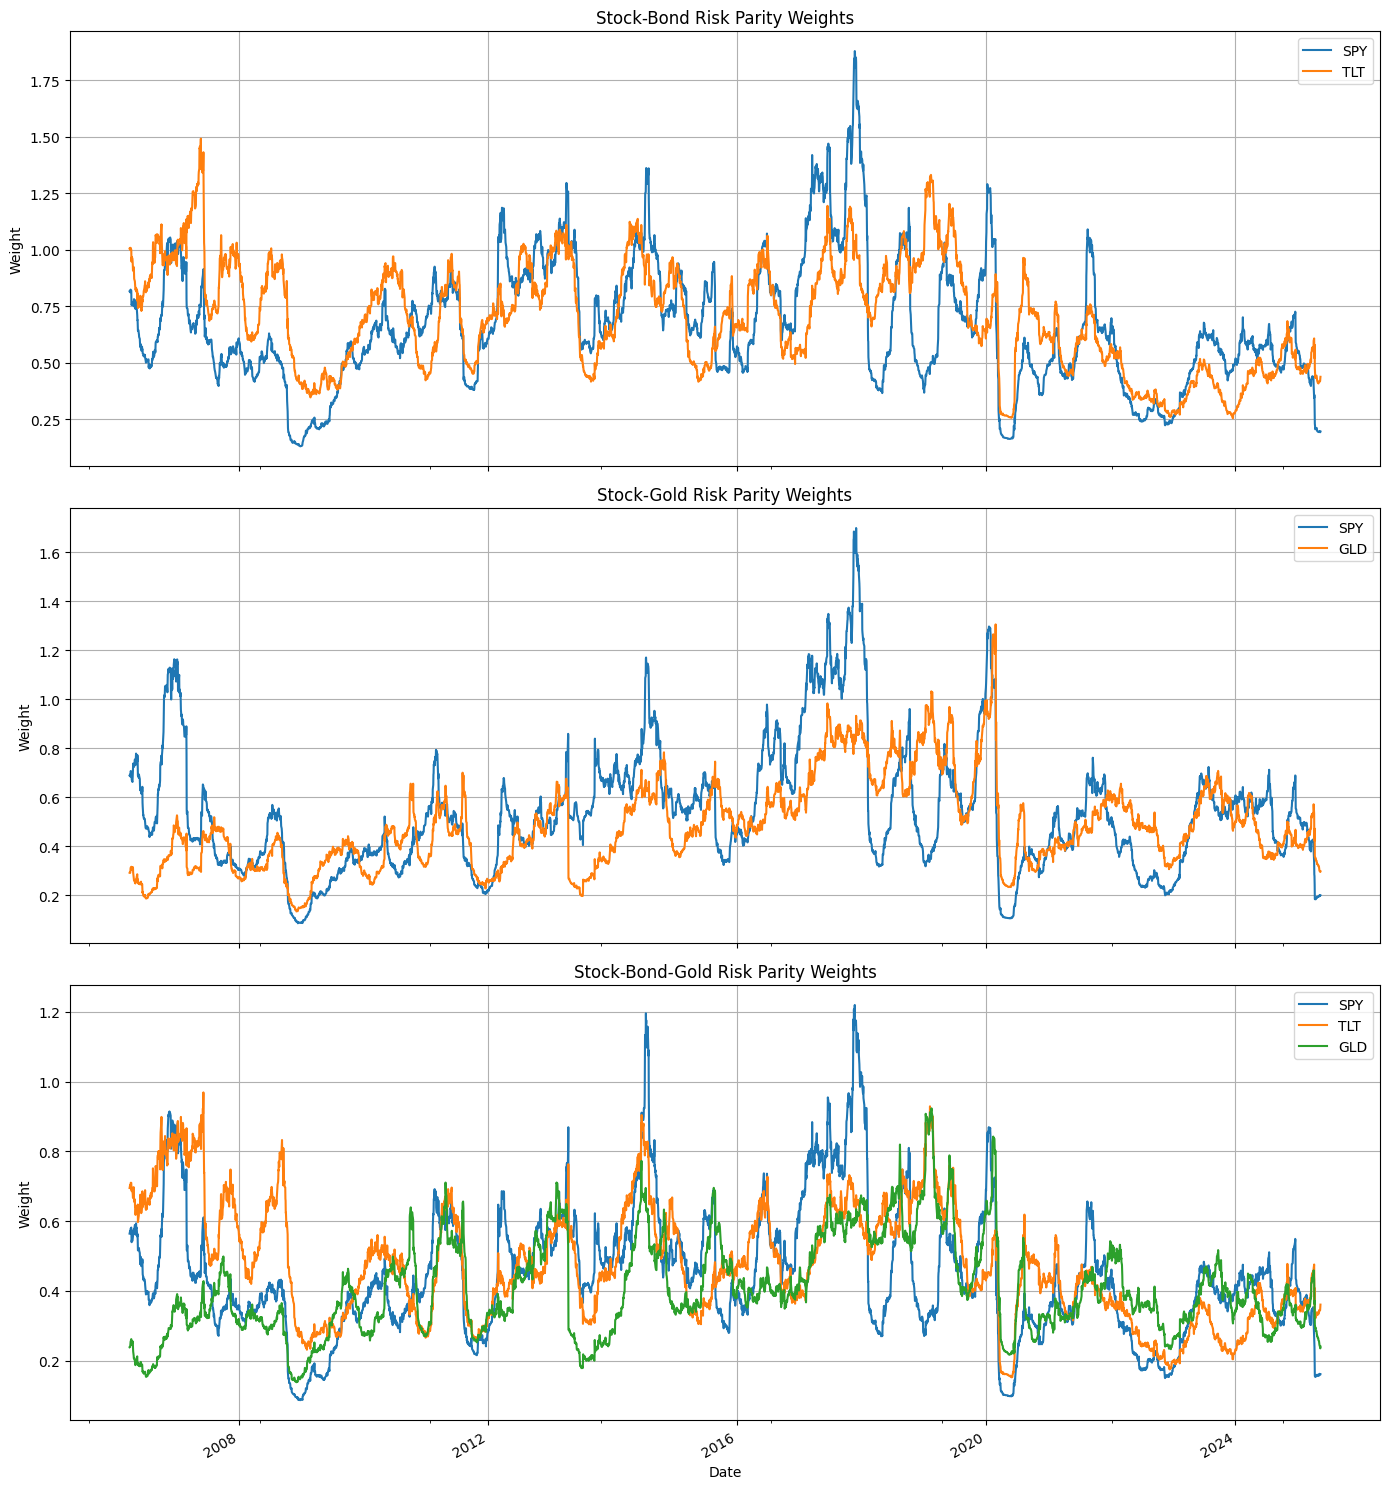

<Figure size 1400x500 with 0 Axes>

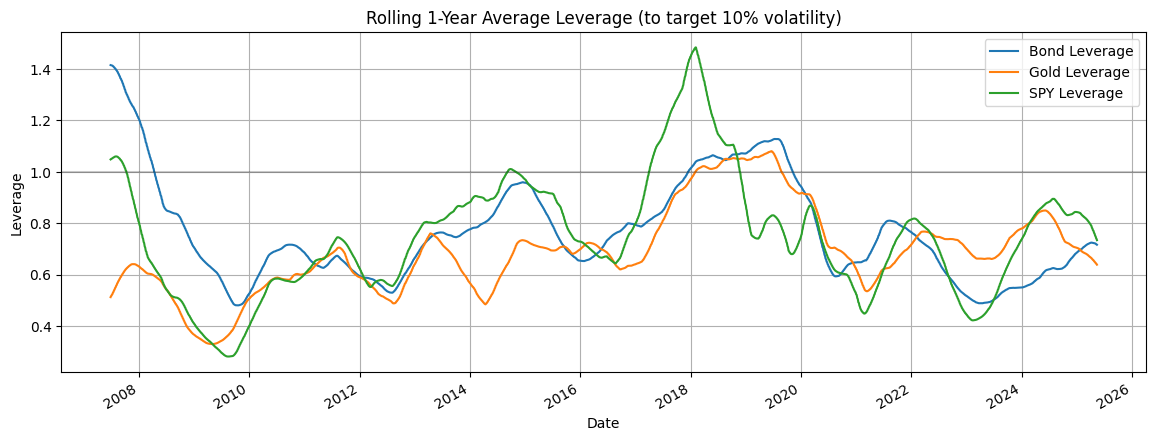

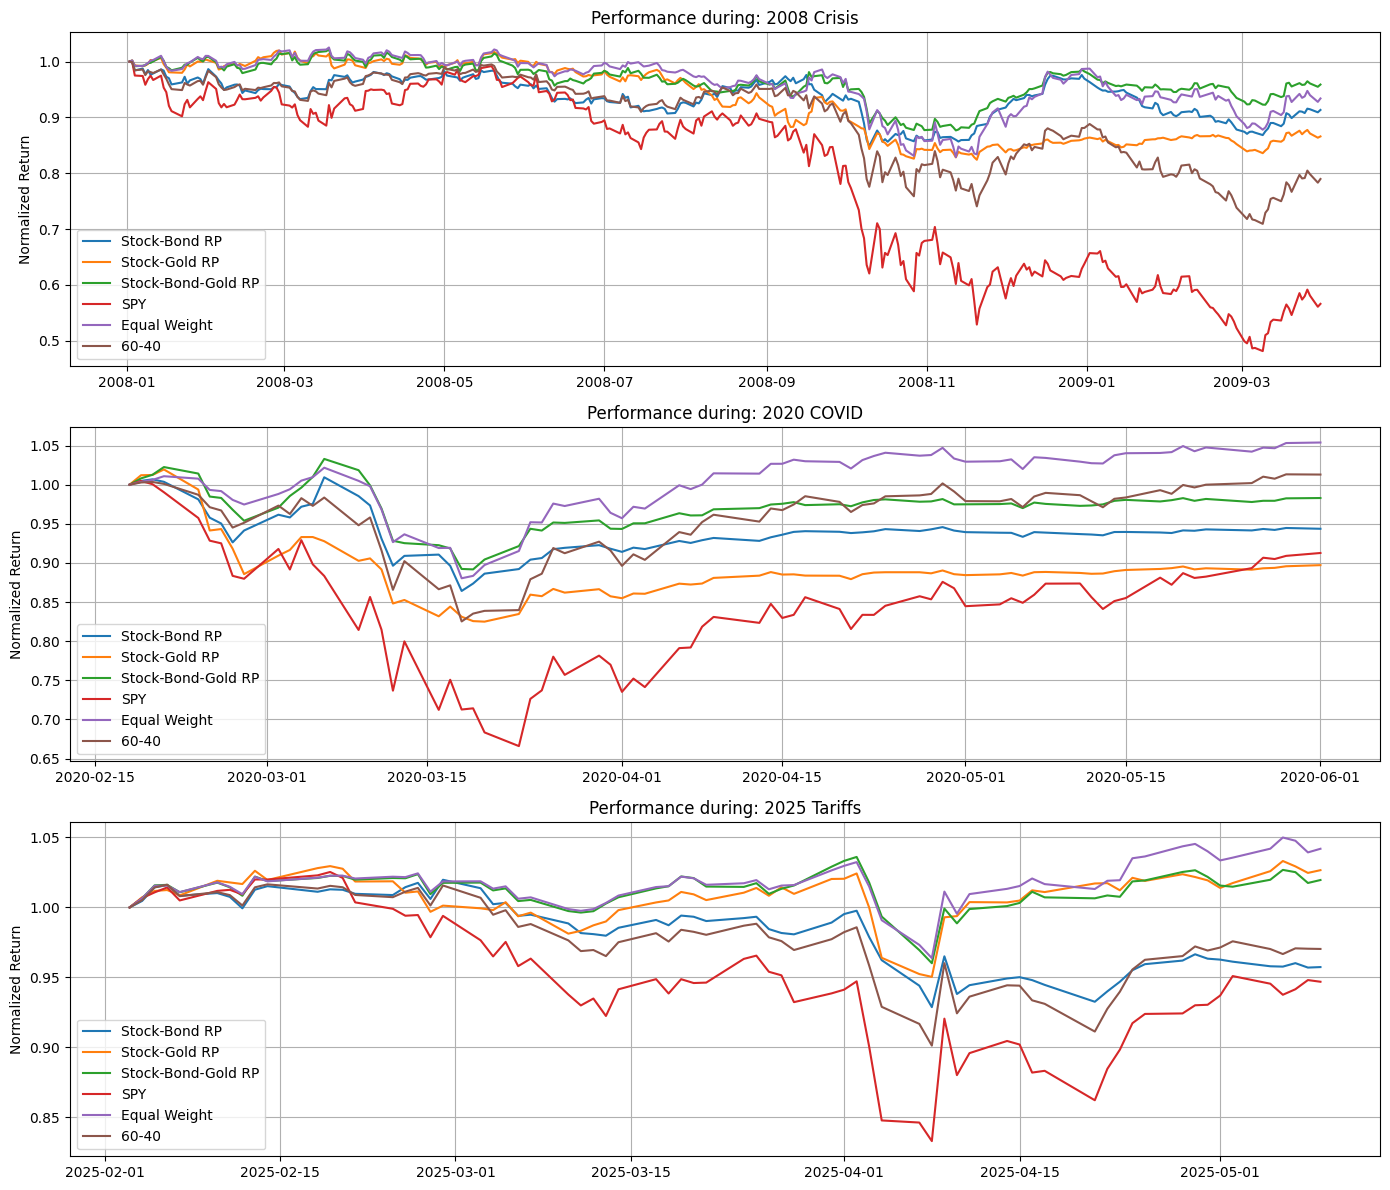

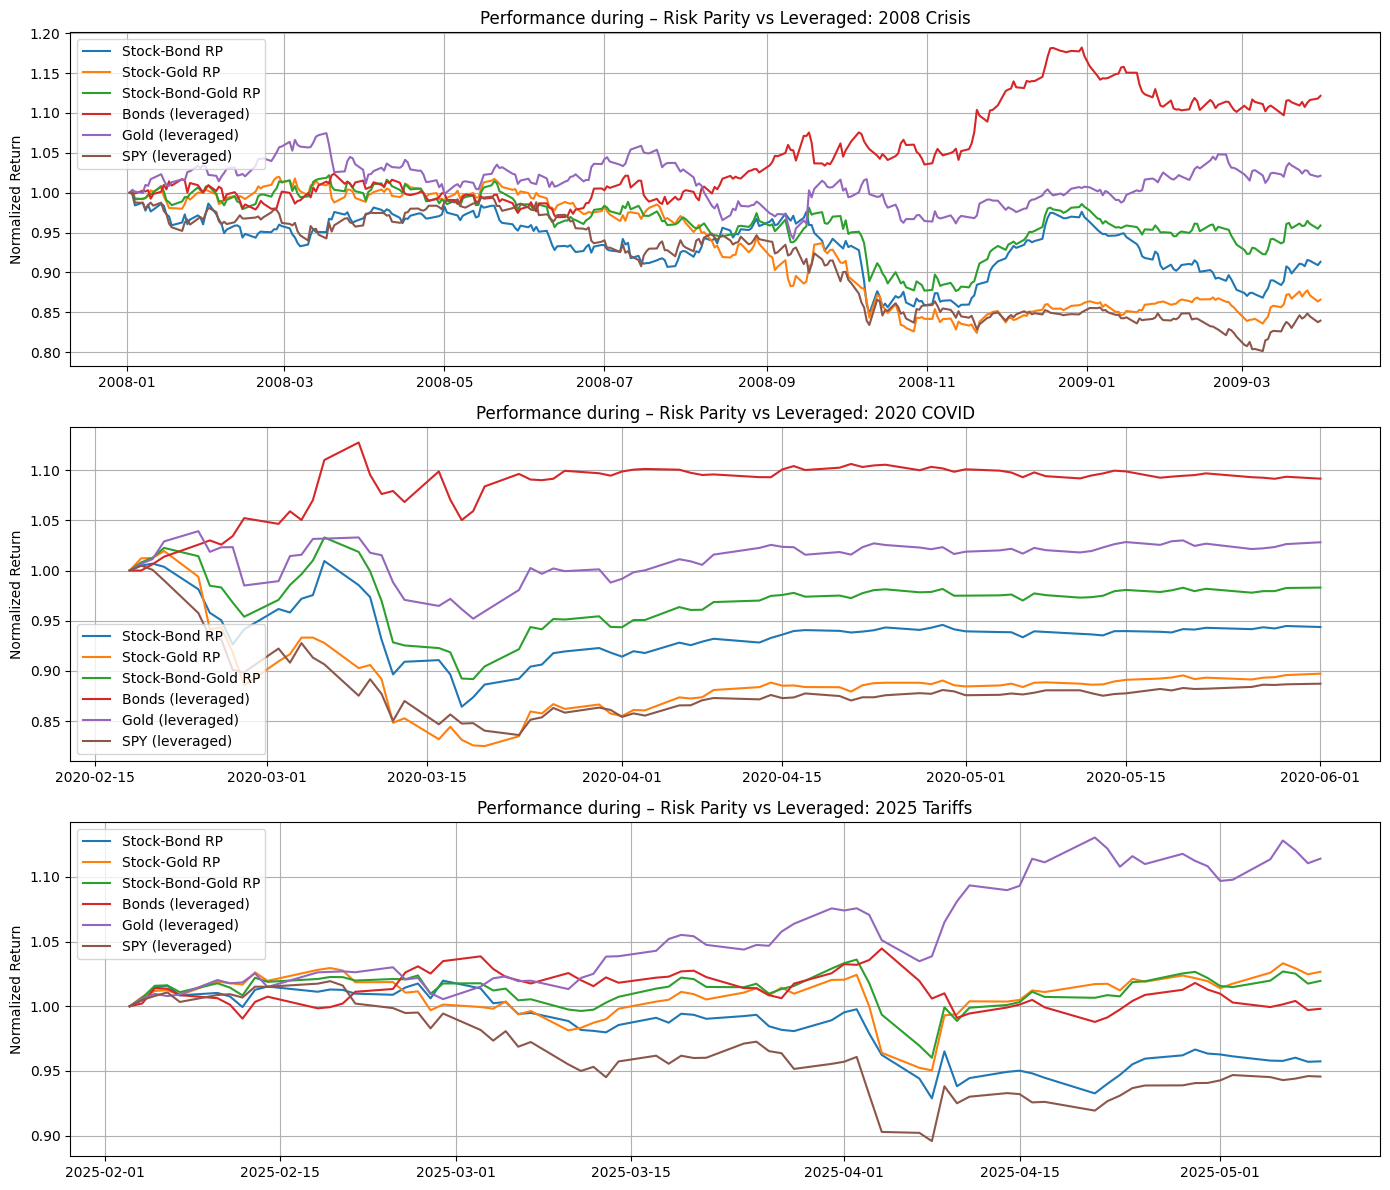

<Figure size 1600x800 with 0 Axes>

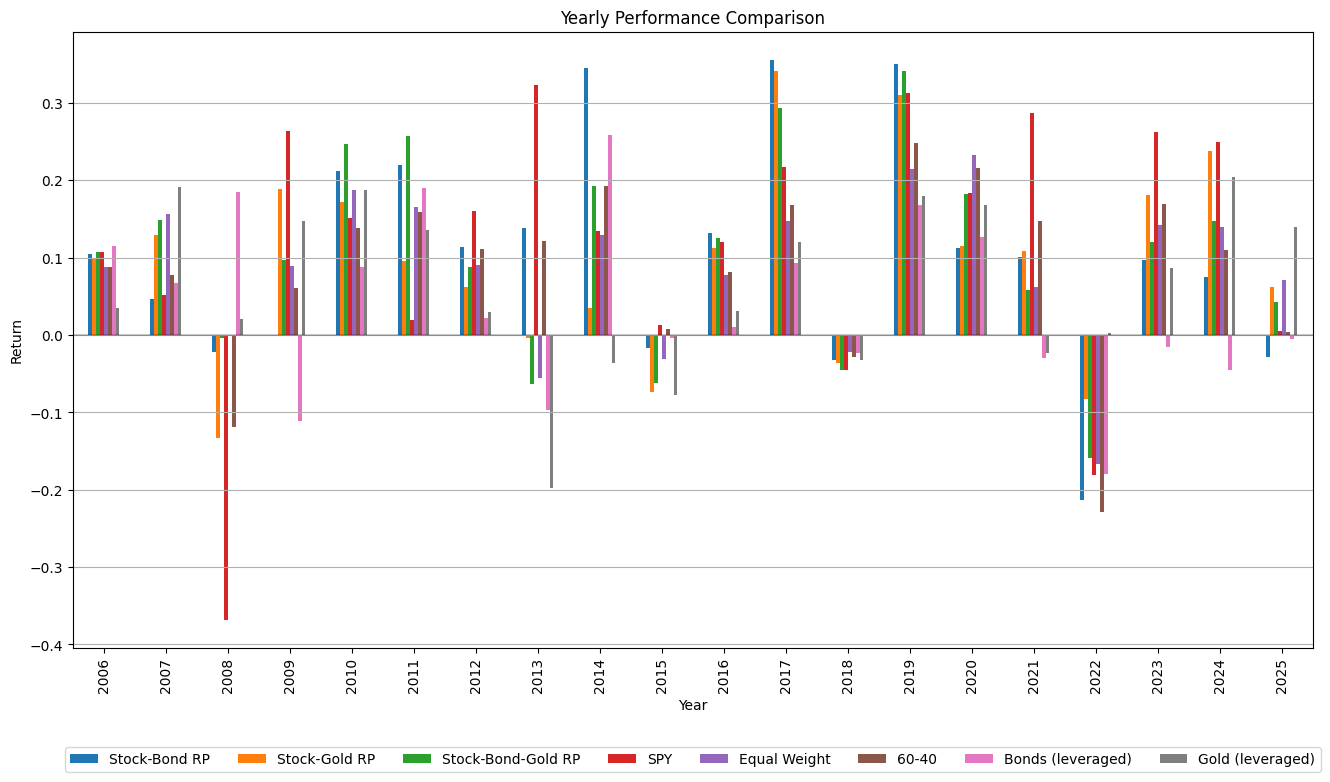

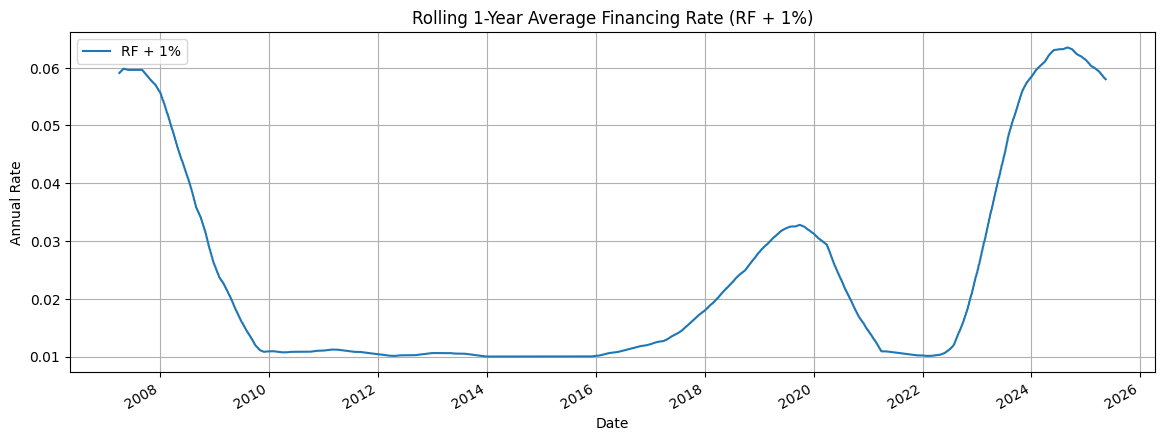

<Figure size 1600x800 with 0 Axes>

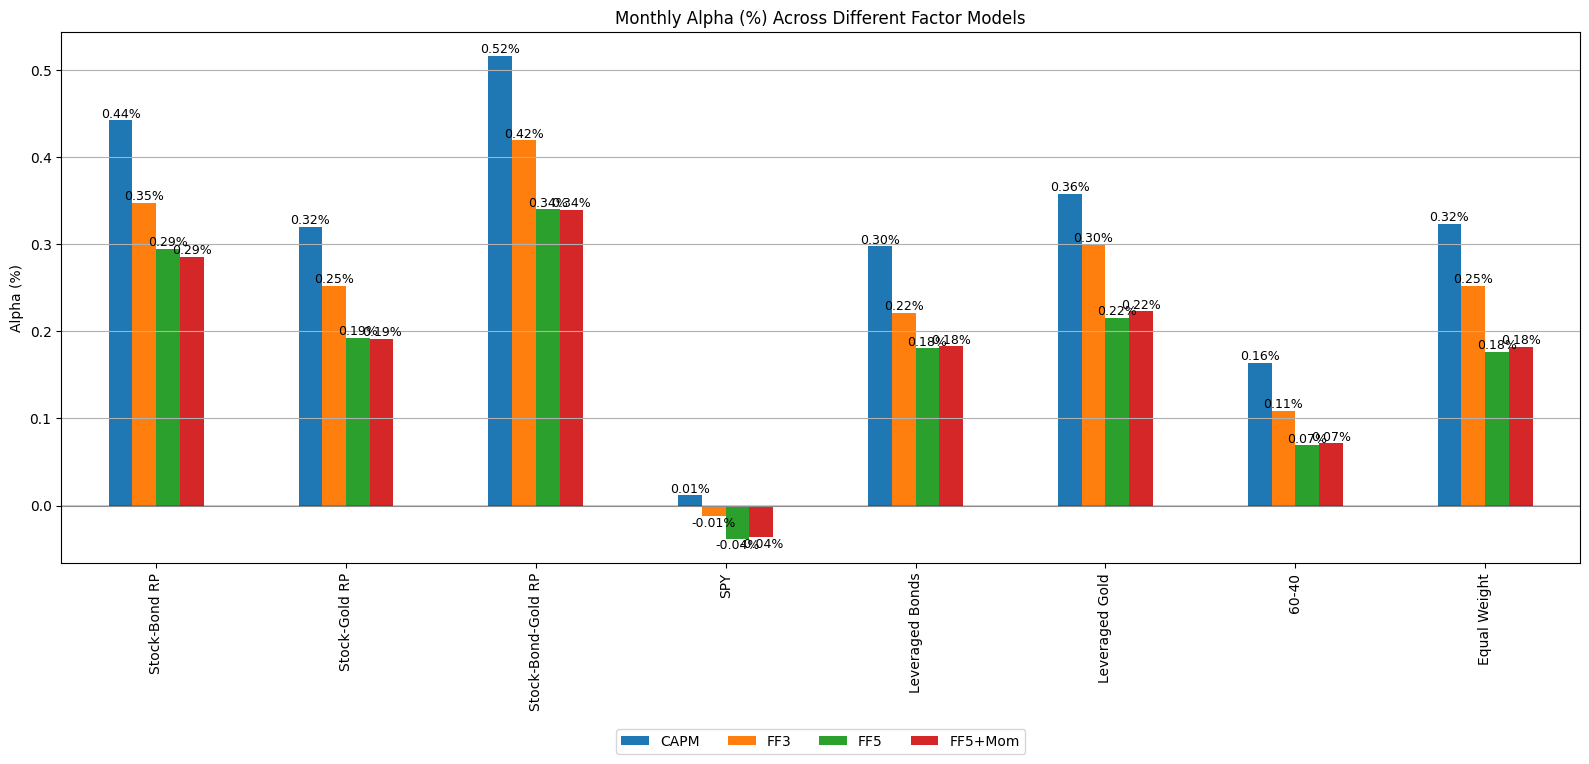

In [ ]:
# risk_parity_refactored.py
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats  # kept since you imported it; not used directly here
import statsmodels.api as sm

# ------------------------------------------------------------
# Configuration
# ------------------------------------------------------------
crisis_periods = {
    "2008 Crisis": ("2008-01-01", "2009-03-31"),
    "2020 COVID": ("2020-02-15", "2020-06-01"),
    "2025 Tariffs": ("2025-02-01", "2025-05-09"),
}
WINDOW_SIZE = 60


# ------------------------------------------------------------
# Data Utilities
# ------------------------------------------------------------
def load_data(filename="data/price_data.csv"):
    """
    Load price data from CSV and convert to returns.
    """
    data = pd.read_csv(filename, index_col=0, parse_dates=True)
    returns = data.pct_change().dropna()
    return returns


def load_rf_rates():
    """
    Load the (monthly) Fama-French RF and convert to daily series.
    """
    ff3 = pd.read_csv("data/F-F_Research_Data_Factors.CSV")
    ff3 = ff3.rename(columns=lambda x: x.strip())
    ff3.rename(columns={ff3.columns[0]: "date"}, inplace=True)
    ff3["date"] = ff3["date"].astype(str)
    ff3["RF"] = pd.to_numeric(ff3["RF"], errors="coerce")

    ff3["datetime"] = pd.to_datetime(ff3["date"], format="%Y%m")
    ff3.set_index("datetime", inplace=True)

    # Convert monthly RF to daily (approx 21 trading days), percent -> decimal if needed.
    if ff3["RF"].mean() > 0.1:
        daily_rf = ff3["RF"] / 100 / 21
    else:
        daily_rf = ff3["RF"] / 21

    daily_rf = daily_rf.resample("D").ffill()
    return daily_rf


def load_ff_data(filename, factor_cols, date_format="%Y%m"):
    """
    Generic loader for Fama-French style CSVs.
    First column is YYYYMM 'date' string; factor_cols are coerced numeric.
    """
    df = pd.read_csv(filename)
    df = df.rename(columns=lambda x: x.strip())
    df.rename(columns={df.columns[0]: "date"}, inplace=True)
    df["date"] = df["date"].astype(str)
    df[factor_cols] = df[factor_cols].apply(pd.to_numeric, errors="coerce")
    return df


def convert_to_monthly(daily_returns):
    """
    Convert daily returns series to monthly (compounded).
    """
    return daily_returns.resample("M").apply(lambda x: (1 + x).prod() - 1)


# ------------------------------------------------------------
# Portfolio Math
# ------------------------------------------------------------
def calculate_volatility(returns, window):
    """
    Rolling annualized volatility of returns.
    """
    return returns.rolling(window=window).std() * np.sqrt(252)


def risk_parity_weights(returns, vol_target, window):
    """
    Risk parity weights using inverse vol base weights and
    exact portfolio vol from rolling covariance matrices.
    """
    vols = calculate_volatility(returns, window=window)
    inv_vols = 1 / vols
    base_w = inv_vols.div(inv_vols.sum(axis=1), axis=0)

    true_vol = []
    for dt in base_w.index:
        w = base_w.loc[dt].values
        windowed = returns.loc[:dt].iloc[-(window + 1) : -1]
        if len(windowed) < 2:
            true_vol.append(np.nan)
            continue
        cov_t = windowed.cov() * 252
        true_vol.append(np.sqrt(w @ cov_t.values @ w))
    portfolio_vol = pd.Series(true_vol, index=base_w.index).ffill()

    leverage = vol_target / portfolio_vol
    scaled_w = base_w.multiply(leverage, axis=0)
    return scaled_w.shift(1).dropna()  # avoid look-ahead


def calculate_portfolio_returns(returns, weights, rf_rates=None, spread=0.01):
    """
    Net portfolio returns = gross - financing cost for leverage > 1x.

    - returns: DataFrame of returns
    - weights: DataFrame of weights (may include leverage)
    - rf_rates: daily RF (decimal, daily)
    - spread: annualized spread (decimal), converted to daily
    """

    gross = (returns * weights).sum(axis=1)
    lev = weights.abs().sum(axis=1)

    if rf_rates is not None:
        aligned_rf = rf_rates.reindex(gross.index, method="ffill")
        daily_financing_rate = aligned_rf + spread / 252
    else:
        annual_financing_rate = 0.03
        daily_financing_rate = (1 + annual_financing_rate) ** (1 / 252) - 1

    financing_cost = (lev - 1).clip(lower=0) * daily_financing_rate
    net = gross - financing_cost
    return net


# ------------------------------------------------------------
# Analysis Helpers
# ------------------------------------------------------------
def evaluate_strategy(returns, name="Strategy"):
    """
    Annualized return/vol, Sharpe, max drawdown, and crisis-period cumulative returns.
    """
    ann_return = returns.mean() * 252
    ann_vol = returns.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol if ann_vol != 0 else 0

    cum = (1 + returns).cumprod()
    running_max = cum.cummax()
    dd = (cum / running_max) - 1
    max_dd = dd.min()

    crisis_perf = {}
    for crisis_name, (start, end) in crisis_periods.items():
        try:
            cr = returns.loc[start:end]
            crisis_perf[crisis_name] = (1 + cr).prod() - 1 if not cr.empty else np.nan
        except Exception:
            crisis_perf[crisis_name] = np.nan

    metrics = {
        "Annualized Return": ann_return,
        "Annualized Volatility": ann_vol,
        "Sharpe Ratio": sharpe,
        "Maximum Drawdown": max_dd,
        **crisis_perf,
    }
    return pd.Series(metrics, name=name)


def compute_leverage_series(series, vol_target, window):
    """
    Rolling leverage to target vol_target for a single asset series.
    Returns (leverage_series, weights_df).
    """
    vol = calculate_volatility(series, window=window).shift(1)
    lev = vol_target / vol
    wdf = pd.DataFrame({series.name: lev}, index=lev.index)
    return lev, wdf


def normalize(series):
    """Normalize a cumulative series to 1 at start."""
    return series / series.iloc[0]


def drawdown_from_cum(cum):
    """Drawdown series from cumulative values."""
    return (cum / cum.cummax()) - 1


# ------------------------------------------------------------
# Regressions
# ------------------------------------------------------------
FACTOR_MODELS = {
    "CAPM": ["Mkt-RF"],
    "FF3": ["Mkt-RF", "SMB", "HML"],
    "FF5": ["Mkt-RF", "SMB", "HML", "RMW", "CMA"],
    "FF5+Momentum": ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "Mom"],
}


def run_regression(portfolio_returns, factor_data, model_type="CAPM", portfolio_name="Portfolio", mom=None):
    """
    Run linear regression of monthly excess returns on FF factors.

    - portfolio_returns: pd.Series (monthly)
    - factor_data: DataFrame with date (YYYYMM) and factors (at least those in model)
    - model_type: "CAPM" | "FF3" | "FF5" | "FF5+Momentum"
    - mom: optional momentum dataframe (with 'date' and 'Mom') used if model_type includes momentum
    """
    df = pd.DataFrame({"ret": portfolio_returns})
    df = df.reset_index()
    index_col = df.columns[0]
    df["date"] = df[index_col].dt.strftime("%Y%m")
    df = df.drop(index_col, axis=1)

    # Merge factors
    merged = pd.merge(df, factor_data.copy(), on="date", how="inner")

    # Add momentum if required
    if "Momentum" in model_type:
        if mom is None:
            raise ValueError("Momentum data 'mom' must be provided for FF5+Momentum.")
        merged = pd.merge(merged, mom.copy(), on="date", how="inner")

    # Excess returns
    if merged["RF"].mean() > 0.1:
        merged["excess_ret"] = merged["ret"] - merged["RF"] / 100
    else:
        merged["excess_ret"] = merged["ret"] - merged["RF"]

    X = sm.add_constant(merged[FACTOR_MODELS[model_type]])
    model = sm.OLS(merged["excess_ret"], X).fit()
    print(f"\n{portfolio_name} {model_type} Regression Results:")
    print(model.summary().tables[1])
    return model


# ------------------------------------------------------------
# Visualization Utilities (DRY)
# ------------------------------------------------------------
# def plot_cumulative(series_dict, title, ylabel="Cumulative Return"):
#     plt.figure(figsize=(14, 7))
#     for name, s in series_dict.items():
#         s_norm = normalize(s)
#         plt.semilogy(s_norm.index, s_norm, label=name)
        
#     plt.title(title)
#     plt.xlabel("Date")
#     plt.ylabel(ylabel)
#     plt.grid(True)
#     plt.legend()

from matplotlib.ticker import NullFormatter

def plot_cumulative(series_dict, title, ylabel="Cumulative Return (log scale)"):
    plt.figure(figsize=(14, 7))
    
    # Plot each cumulative series on log scale
    for name, s in series_dict.items():
        s_norm = s / s.iloc[0]  # normalize start to 1×
        plt.semilogy(s_norm.index, s_norm, label=name)
    
    ax = plt.gca()
    
    # Remove all existing log ticks before adding your own
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_minor_formatter(NullFormatter())
    
    # Auto-generate "×" tick labels (e.g., 1×, 2×, 4×, 8×)
    ymin, ymax = ax.get_ylim()
    yticks = np.geomspace(1, ymax, num=8)
    ax.set_yticks(yticks)
    ax.set_yticklabels([f"{y:.1f}×" for y in yticks])
    
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.grid(True, which="both", linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()


def plot_drawdowns(series_dict, title):
    plt.figure(figsize=(14, 6))
    for name, s in series_dict.items():
        dd = drawdown_from_cum(normalize((1 + s).cumprod()))
        plt.plot(dd.index, dd, label=name)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Drawdown")
    plt.grid(True)
    plt.legend(loc="lower left")
    plt.axhline(y=0, linestyle="-", alpha=0.3, color="black")
    plt.tight_layout()


def plot_weights(weight_frames, titles):
    rows = len(weight_frames)
    fig, axes = plt.subplots(rows, 1, figsize=(14, 5 * rows), sharex=True)
    if rows == 1:
        axes = [axes]
    for ax, wdf, ttl in zip(axes, weight_frames, titles):
        wdf.plot(ax=ax, title=ttl)
        ax.set_ylabel("Weight")
        ax.grid(True)
        ax.legend()
    plt.tight_layout()


def plot_crisis_panels(cum_series_dicts, title_prefix):
    """
    cum_series_dicts: dict[name -> cumulative series]
    Plots each crisis in its own panel using the same set of series.
    """
    fig, axes = plt.subplots(len(crisis_periods), 1, figsize=(14, 4 * len(crisis_periods)), sharex=False)
    if len(crisis_periods) == 1:
        axes = [axes]

    for i, (crisis_name, (start, end)) in enumerate(crisis_periods.items()):
        ax = axes[i]
        try:
            for name, cum in cum_series_dicts.items():
                sub = cum.loc[start:end]
                if len(sub) < 1:
                    continue
                ax.plot(sub.index, normalize(sub), label=name)
            ax.set_title(f"{title_prefix}: {crisis_name}")
            ax.set_ylabel("Normalized Return")
            ax.grid(True)
            ax.legend()
        except Exception:
            ax.text(
                0.5,
                0.5,
                f"Not enough data for {crisis_name}",
                horizontalalignment="center",
                verticalalignment="center",
            )
    plt.tight_layout()


def plot_yearly_performance(yearly_df, title="Yearly Performance Comparison"):
    plt.figure(figsize=(16, 8))
    ax = yearly_df.plot(kind="bar", figsize=(16, 8))
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Return")
    plt.grid(True, axis="y")
    plt.axhline(y=0, color="black", linestyle="-", alpha=0.2)
    plt.legend(loc="upper center", ncol=min(8, yearly_df.shape[1]), bbox_to_anchor=(0.5, -0.15))


def plot_alphas(alpha_df):
    alphas = alpha_df * 100  # monthly % for display
    plt.figure(figsize=(16, 8))
    ax = alphas.plot(kind="bar", figsize=(16, 8))
    plt.title("Monthly Alpha (%) Across Different Factor Models")
    plt.ylabel("Alpha (%)")
    plt.grid(True, axis="y")
    plt.axhline(y=0, color="black", linestyle="-", alpha=0.2)
    plt.legend(loc="upper center", ncol=4, bbox_to_anchor=(0.5, -0.3))

    # Value labels
    for p in ax.patches:
        h = p.get_height()
        if np.isfinite(h):
            ax.annotate(
                f"{h/100:.2%}",
                (p.get_x() + p.get_width() / 2.0, h),
                ha="center",
                va="bottom" if h >= 0 else "top",
                fontsize=9,
            )
    plt.tight_layout()


# ------------------------------------------------------------
# Master Runner (same functionality, DRY)
# ------------------------------------------------------------
def run_risk_parity_comparison(filename="data/price_data.csv", vol_target=0.10, financing_spread=0.01):
    # Load
    all_data = load_data(filename)
    rf_rates_daily = load_rf_rates()

    # Strategy universes
    stock_bond_cols = ["SPY", "TLT"]
    stock_gold_cols = ["SPY", "GLD"]
    all3_cols = ["SPY", "TLT", "GLD"]

    sb_data = all_data[stock_bond_cols]
    sg_data = all_data[stock_gold_cols]
    sbg_data = all_data[all3_cols]

    # Risk parity weights
    sb_w = risk_parity_weights(sb_data, vol_target=vol_target, window=WINDOW_SIZE)
    sg_w = risk_parity_weights(sg_data, vol_target=vol_target, window=WINDOW_SIZE)
    sbg_w = risk_parity_weights(sbg_data, vol_target=vol_target, window=WINDOW_SIZE)

    # Portfolio returns (net of financing)
    portfolios = {
        "Stock-Bond RP": (sb_data, sb_w),
        "Stock-Gold RP": (sg_data, sg_w),
        "Stock-Bond-Gold RP": (sbg_data, sbg_w),
    }
    port_rets = {
        name: calculate_portfolio_returns(data.loc[w.index], w, rf_rates=rf_rates_daily, spread=financing_spread)
        for name, (data, w) in portfolios.items()
    }

    # Individual assets (aligned)
    # Use the common index from RP strategies
    common_index = None
    for s in port_rets.values():
        common_index = s.index if common_index is None else common_index.intersection(s.index)

    spy_r = all_data["SPY"].loc[common_index]
    tlt_r = all_data["TLT"].loc[common_index]
    gld_r = all_data["GLD"].loc[common_index]

    # Vol-targeted leverage for individual assets
    spy_lev, spy_wdf = compute_leverage_series(spy_r, vol_target, WINDOW_SIZE)
    tlt_lev, tlt_wdf = compute_leverage_series(tlt_r, vol_target, WINDOW_SIZE)
    gld_lev, gld_wdf = compute_leverage_series(gld_r, vol_target, WINDOW_SIZE)

    # Leveraged individual asset returns (net of financing)
    lev_spy = calculate_portfolio_returns(pd.DataFrame({"SPY": spy_r}), spy_wdf, rf_rates=rf_rates_daily, spread=financing_spread)
    lev_tlt = calculate_portfolio_returns(pd.DataFrame({"TLT": tlt_r}), tlt_wdf, rf_rates=rf_rates_daily, spread=financing_spread)
    lev_gld = calculate_portfolio_returns(pd.DataFrame({"GLD": gld_r}), gld_wdf, rf_rates=rf_rates_daily, spread=financing_spread)

    # Static portfolios
    eqw = (spy_r + tlt_r + gld_r) / 3
    sixty_forty = 0.6 * spy_r + 0.4 * tlt_r

    # Align everything on a shared index
    series_to_align = [
        *port_rets.values(),
        spy_r,
        lev_spy,
        lev_tlt,
        lev_gld,
        eqw,
        sixty_forty,
    ]
    idx = series_to_align[0].index
    for s in series_to_align[1:]:
        idx = idx.intersection(s.index)

    for k in list(port_rets.keys()):
        port_rets[k] = port_rets[k].loc[idx]
    spy_r = spy_r.loc[idx]
    lev_spy = lev_spy.loc[idx]
    lev_tlt = lev_tlt.loc[idx]
    lev_gld = lev_gld.loc[idx]
    eqw = eqw.loc[idx]
    sixty_forty = sixty_forty.loc[idx]
    spy_lev = spy_lev.loc[idx]
    tlt_lev = tlt_lev.loc[idx]
    gld_lev = gld_lev.loc[idx]

    # Metrics
    metrics = pd.concat(
        [
            evaluate_strategy(port_rets["Stock-Bond RP"], "Stock-Bond RP"),
            evaluate_strategy(port_rets["Stock-Gold RP"], "Stock-Gold RP"),
            evaluate_strategy(port_rets["Stock-Bond-Gold RP"], "Stock-Bond-Gold RP"),
            evaluate_strategy(spy_r, "SPY (unleveraged)"),
            evaluate_strategy(lev_spy, "SPY (leveraged)"),
            evaluate_strategy(lev_tlt, "Bonds (leveraged)"),
            evaluate_strategy(lev_gld, "Gold (leveraged)"),
            evaluate_strategy(eqw, "Equal Weight"),
            evaluate_strategy(sixty_forty, "60-40"),
        ],
        axis=1,
    )

    # Cumulative series for plotting
    cum = lambda r: (1 + r).cumprod()
    cum_series = {
        "Stock-Bond RP": cum(port_rets["Stock-Bond RP"]),
        "Stock-Gold RP": cum(port_rets["Stock-Gold RP"]),
        "Stock-Bond-Gold RP": cum(port_rets["Stock-Bond-Gold RP"]),
        "SPY (unleveraged)": cum(spy_r),
        "Equal Weight": cum(eqw),
        "60-40": cum(sixty_forty),
    }
    cum_lev = {
        "Stock-Bond RP": cum(port_rets["Stock-Bond RP"]),
        "Stock-Gold RP": cum(port_rets["Stock-Gold RP"]),
        "Stock-Bond-Gold RP": cum(port_rets["Stock-Bond-Gold RP"]),
        "Bonds (leveraged)": cum(lev_tlt),
        "Gold (leveraged)": cum(lev_gld),
        "SPY (leveraged)": cum(lev_spy),
    }

    # Plots
    plot_cumulative(
        {k: v for k, v in cum_series.items() if k in ["Stock-Bond RP", "Stock-Gold RP", "Stock-Bond-Gold RP", "SPY (unleveraged)", "Equal Weight", "60-40"]},
        f"Cumulative Returns Comparison - Risk Parity vs Market (Vol Target: {vol_target*100:.0f}%)",
    )
    plot_cumulative(
        cum_lev,
        f"Cumulative Returns - Risk Parity vs Leveraged Individual Assets (Vol Target: {vol_target*100:.0f}%)",
    )

    # Drawdowns
    plot_drawdowns(
        {
            "Stock-Bond-Gold RP": port_rets["Stock-Bond-Gold RP"],
            "60-40": sixty_forty,
            "Equal Weight": eqw,
            "SPY": spy_r,
        },
        "Drawdowns – Risk Parity vs 60-40, Equal Weight, SPY",
    )
    plot_drawdowns(
        {
            "Stock-Bond-Gold RP": port_rets["Stock-Bond-Gold RP"],
            "Leveraged Bonds": lev_tlt,
            "Leveraged Gold": lev_gld,
            "Leveraged SPY": lev_spy,
        },
        "Drawdowns – Leveraged Individual Assets",
    )

    # Weight panels
    plot_weights(
        [sb_w, sg_w, sbg_w],
        ["Stock-Bond Risk Parity Weights", "Stock-Gold Risk Parity Weights", "Stock-Bond-Gold Risk Parity Weights"],
    )

    # Rolling 1-year average leverage plot
    plt.figure(figsize=(14, 5))
    avg_lev = pd.DataFrame({"Bond Leverage": tlt_lev, "Gold Leverage": gld_lev, "SPY Leverage": spy_lev})
    avg_lev.rolling(window=252).mean().plot(figsize=(14, 5))
    plt.title("Rolling 1-Year Average Leverage (to target 10% volatility)")
    plt.xlabel("Date")
    plt.ylabel("Leverage")
    plt.grid(True)
    plt.axhline(y=1, color="black", linestyle="-", alpha=0.2)

    # Crisis panels (RP vs others)
    plot_crisis_panels(
        {
            "Stock-Bond RP": cum_series["Stock-Bond RP"],
            "Stock-Gold RP": cum_series["Stock-Gold RP"],
            "Stock-Bond-Gold RP": cum_series["Stock-Bond-Gold RP"],
            "SPY": cum_series["SPY (unleveraged)"],
            "Equal Weight": cum_series["Equal Weight"],
            "60-40": cum_series["60-40"],
        },
        "Performance during",
    )

    # Crisis panels (RP vs leveraged)
    plot_crisis_panels(
        {
            "Stock-Bond RP": cum_lev["Stock-Bond RP"],
            "Stock-Gold RP": cum_lev["Stock-Gold RP"],
            "Stock-Bond-Gold RP": cum_lev["Stock-Bond-Gold RP"],
            "Bonds (leveraged)": cum_lev["Bonds (leveraged)"],
            "Gold (leveraged)": cum_lev["Gold (leveraged)"],
            "SPY (leveraged)": cum_lev["SPY (leveraged)"],
        },
        "Performance during – Risk Parity vs Leveraged",
    )

    # Yearly performance bar chart
    yearly = pd.DataFrame(
        {
            "Stock-Bond RP": port_rets["Stock-Bond RP"].resample("Y").apply(lambda x: (1 + x).prod() - 1),
            "Stock-Gold RP": port_rets["Stock-Gold RP"].resample("Y").apply(lambda x: (1 + x).prod() - 1),
            "Stock-Bond-Gold RP": port_rets["Stock-Bond-Gold RP"].resample("Y").apply(lambda x: (1 + x).prod() - 1),
            "SPY": spy_r.resample("Y").apply(lambda x: (1 + x).prod() - 1),
            "Equal Weight": eqw.resample("Y").apply(lambda x: (1 + x).prod() - 1),
            "60-40": sixty_forty.resample("Y").apply(lambda x: (1 + x).prod() - 1),
            "Bonds (leveraged)": lev_tlt.resample("Y").apply(lambda x: (1 + x).prod() - 1),
            "Gold (leveraged)": lev_gld.resample("Y").apply(lambda x: (1 + x).prod() - 1),
        }
    )
    yearly.index = yearly.index.year
    plot_yearly_performance(yearly)

    # Financing rate panel
    plt.figure(figsize=(14, 5))
    aligned_rf = rf_rates_daily.reindex(port_rets["Stock-Bond RP"].index, method="ffill")
    financing_rate = (aligned_rf + 0.01 / 252) * 252
    financing_rate.rolling(window=252).mean().plot(label="RF + 1%")
    plt.title("Rolling 1-Year Average Financing Rate (RF + 1%)")
    plt.xlabel("Date")
    plt.ylabel("Annual Rate")
    plt.grid(True)
    plt.legend()

    # Outputs dictionary
    out = {
        "metrics": metrics,
        "stock_bond_returns": port_rets["Stock-Bond RP"],
        "stock_gold_returns": port_rets["Stock-Gold RP"],
        "stock_bond_gold_returns": port_rets["Stock-Bond-Gold RP"],
        "spy_returns": spy_r,
        "leveraged_bond_returns": lev_tlt,
        "leveraged_gold_returns": lev_gld,
        "leveraged_spy_returns": lev_spy,
        "equal_weight_returns": eqw,
        "sixty_forty_returns": sixty_forty,
        "bond_leverage": tlt_lev,
        "gold_leverage": gld_lev,
        "spy_leverage": spy_lev,
        "yearly_returns": yearly,
        "stock_bond_weights": sb_w,
        "stock_gold_weights": sg_w,
        "stock_bond_gold_weights": sbg_w,
        "rf_rates": aligned_rf,
        "financing_rate": financing_rate,
    }
    return out


# ------------------------------------------------------------
# Script-style execution (kept for parity with your original flow)
# ------------------------------------------------------------
def _print_dashboard(results):
    print("\nPerformance Metrics:")
    print(results["metrics"])

    # Correlations (including 3-asset RP)
    corr_pairs = [
        ("stock_bond_returns", "stock_gold_returns", "Stock-Bond RP vs Stock-Gold RP"),
        ("stock_bond_returns", "stock_bond_gold_returns", "Stock-Bond RP vs Stock-Bond-Gold RP"),
        ("stock_gold_returns", "stock_bond_gold_returns", "Stock-Gold RP vs Stock-Bond-Gold RP"),
        ("stock_bond_returns", "spy_returns", "Stock-Bond RP vs SPY"),
        ("stock_gold_returns", "spy_returns", "Stock-Gold RP vs SPY"),
        ("stock_bond_gold_returns", "spy_returns", "Stock-Bond-Gold RP vs SPY"),
    ]
    print("\nCorrelation Analysis:")
    for a, b, label in corr_pairs:
        print(f"{label}: {results[a].corr(results[b]):.4f}")

    # Regime analysis (replicates your logic: MA on returns, not price)
    spy_returns = results["spy_returns"]
    spy_ma200 = spy_returns.rolling(window=200).mean()
    bull_idx = spy_returns[spy_returns > spy_ma200].index
    bear_idx = spy_returns[spy_returns < spy_ma200].index

    def ann_mean(s, idx):
        return s.loc[idx].mean() * 252 if len(idx) else np.nan

    bull = {
        "Stock-Bond RP": ann_mean(results["stock_bond_returns"], bull_idx),
        "Stock-Gold RP": ann_mean(results["stock_gold_returns"], bull_idx),
        "Stock-Bond-Gold RP": ann_mean(results["stock_bond_gold_returns"], bull_idx),
        "SPY": ann_mean(results["spy_returns"], bull_idx),
        "Leveraged Bonds": ann_mean(results["leveraged_bond_returns"], bull_idx),
        "Leveraged Gold": ann_mean(results["leveraged_gold_returns"], bull_idx),
    }
    bear = {
        "Stock-Bond RP": ann_mean(results["stock_bond_returns"], bear_idx),
        "Stock-Gold RP": ann_mean(results["stock_gold_returns"], bear_idx),
        "Stock-Bond-Gold RP": ann_mean(results["stock_bond_gold_returns"], bear_idx),
        "SPY": ann_mean(results["spy_returns"], bear_idx),
        "Leveraged Bonds": ann_mean(results["leveraged_bond_returns"], bear_idx),
        "Leveraged Gold": ann_mean(results["leveraged_gold_returns"], bear_idx),
    }

    print("\nRegime Analysis - Performance in Different Market Conditions:")
    print("Bull Market Performance:")
    for k, v in bull.items():
        print(f"  {k:20s} {v:.4f}")
    print("Bear Market Performance:")
    for k, v in bear.items():
        print(f"  {k:20s} {v:.4f}")

    # Crisis performance summary table
    crisis_rows = ["2008 Crisis", "2020 COVID", "2025 Tariffs"]
    crisis_perf = results["metrics"].loc[crisis_rows]
    print("\nCrisis Performance Summary:")
    print(crisis_perf)


def _run_factor_regressions(results):
    print("\nRunning Factor Regressions...")
    ff3 = load_ff_data("data/F-F_Research_Data_Factors.CSV", ["Mkt-RF", "SMB", "HML", "RF"])
    ff5 = load_ff_data("data/F-F_Research_Data_5_Factors_2x3.csv", ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "RF"])
    mom = load_ff_data("data/F-F_Momentum_Factor.CSV", ["Mom"])

    # Monthly returns (including 3-asset RP)
    to_monthly = lambda s: convert_to_monthly(s)
    sb_m = to_monthly(results["stock_bond_returns"])
    sg_m = to_monthly(results["stock_gold_returns"])
    sbg_m = to_monthly(results["stock_bond_gold_returns"])
    spy_m = to_monthly(results["spy_returns"])
    lev_bond_m = to_monthly(results["leveraged_bond_returns"])
    lev_gold_m = to_monthly(results["leveraged_gold_returns"])
    sixty_forty_m = to_monthly(results["sixty_forty_returns"])
    eqw_m = to_monthly(results["equal_weight_returns"])

    # Helper to run a suite on a dict of series
    def suite(series_dict, labels):
        models = {}
        for k, s in series_dict.items():
            models.setdefault(k, {})
            models[k]["CAPM"] = run_regression(s, ff3, "CAPM", labels[k])
            models[k]["FF3"] = run_regression(s, ff3, "FF3", labels[k])
            models[k]["FF5"] = run_regression(s, ff5, "FF5", labels[k])
            models[k]["FF5+Momentum"] = run_regression(s, ff5, "FF5+Momentum", labels[k], mom=mom)
        return models

    series_dict = {
        "SB": sb_m,
        "SG": sg_m,
        "SBG": sbg_m,
        "SPY": spy_m,
        "LB": lev_bond_m,
        "LG": lev_gold_m,
        "6040": sixty_forty_m,
        "EQW": eqw_m,
    }
    labels = {
        "SB": "Stock-Bond RP",
        "SG": "Stock-Gold RP",
        "SBG": "Stock-Bond-Gold RP",
        "SPY": "SPY",
        "LB": "Leveraged Bonds",
        "LG": "Leveraged Gold",
        "6040": "60-40",
        "EQW": "Equal Weight",
    }
    models = suite(series_dict, labels)

    # Alpha table
    alpha = pd.DataFrame(
        {
            "CAPM": [
                models["SB"]["CAPM"].params["const"],
                models["SG"]["CAPM"].params["const"],
                models["SBG"]["CAPM"].params["const"],
                models["SPY"]["CAPM"].params["const"],
                models["LB"]["CAPM"].params["const"],
                models["LG"]["CAPM"].params["const"],
                models["6040"]["CAPM"].params["const"],
                models["EQW"]["CAPM"].params["const"],
            ],
            "FF3": [
                models["SB"]["FF3"].params["const"],
                models["SG"]["FF3"].params["const"],
                models["SBG"]["FF3"].params["const"],
                models["SPY"]["FF3"].params["const"],
                models["LB"]["FF3"].params["const"],
                models["LG"]["FF3"].params["const"],
                models["6040"]["FF3"].params["const"],
                models["EQW"]["FF3"].params["const"],
            ],
            "FF5": [
                models["SB"]["FF5"].params["const"],
                models["SG"]["FF5"].params["const"],
                models["SBG"]["FF5"].params["const"],
                models["SPY"]["FF5"].params["const"],
                models["LB"]["FF5"].params["const"],
                models["LG"]["FF5"].params["const"],
                models["6040"]["FF5"].params["const"],
                models["EQW"]["FF5"].params["const"],
            ],
            "FF5+Mom": [
                models["SB"]["FF5+Momentum"].params["const"],
                models["SG"]["FF5+Momentum"].params["const"],
                models["SBG"]["FF5+Momentum"].params["const"],
                models["SPY"]["FF5+Momentum"].params["const"],
                models["LB"]["FF5+Momentum"].params["const"],
                models["LG"]["FF5+Momentum"].params["const"],
                models["6040"]["FF5+Momentum"].params["const"],
                models["EQW"]["FF5+Momentum"].params["const"],
            ],
        },
        index=[
            "Stock-Bond RP",
            "Stock-Gold RP",
            "Stock-Bond-Gold RP",
            "SPY",
            "Leveraged Bonds",
            "Leveraged Gold",
            "60-40",
            "Equal Weight",
        ],
    )
    plot_alphas(alpha)
    return alpha, models


# ------------------------------------------------------------
# Main (so you can also run as a script)
# ------------------------------------------------------------
if __name__ == "__main__":
    results = run_risk_parity_comparison(filename="data/price_data.csv", vol_target=0.12, financing_spread=0.01)
    _print_dashboard(results)

    # Factor regressions + alpha bar chart
    alpha_df, models = _run_factor_regressions(results)

    # Show all figures at end for script runs
    plt.show()